In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint ,TensorBoard, EarlyStopping
import tensorflow as tf
import datetime, IPython
import numpy as np
import os


In [2]:

config=tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU')) 


True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def stop_cuda():
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()

In [4]:
path = os.getcwd()

In [5]:
#train_dir = '/home/jidesh/ML/CNN/Facial-expression/data/train'
train_dir = path+'/dataset/FacialExpression-Dataset/Train'
val_dir = path+'/dataset/FacialExpression-Dataset/Test'

checkpoint_losspath = path+'/Checkpoints/checkpoints_loss/Model-epoch_{epoch:02d}--val_loss_{val_loss:.2f}'
checkpoint_accpath = path+'/Checkpoints/checkpoints_acc/Model-epoch_{epoch:02d}--val_categorical_accuracy_{val_categorical_accuracy:.2f}'


train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 64
img_width = 48
img_height = 48

print("Train : ",train_dir)
print("Val : ",val_dir)

Train :  d:\project\project/dataset/FacialExpression-Dataset/Train
Val :  d:\project\project/dataset/FacialExpression-Dataset/Test


In [6]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')


Found 76577 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
print("Train set size : {} class : {} no.of : {}".format(train_generator.samples,train_generator.class_indices,train_generator.num_classes))
train_sample_size = train_generator.samples
validation_sample_size = validation_generator.samples
print("validate set size : {} class : {} no.of : {}".format(validation_generator.samples,validation_generator.class_indices,validation_generator.num_classes))

Train set size : 76577 class : {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6} no.of : 7
validate set size : 7178 class : {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6} no.of : 7


In [8]:
emotion_model = Sequential()
 
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',input_shape=(img_height,img_width,1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.3))
 
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.3))


emotion_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))

emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.3))
 
emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(train_generator.num_classes, activation='softmax'))
################################################################################
#emotion_model.load_weights(path+'/Models/emotion-reg-weight-0.8510841131210327.h5')

In [9]:
emotion_dict = train_generator.class_indices
print(emotion_dict)
#swapping key and values in dictionary
emotion_dict={value:key for key, value in emotion_dict.items()}
print(emotion_dict)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [10]:
checkpoint_loss = ModelCheckpoint(
    filepath=checkpoint_losspath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose =1
)
checkpoint_acc = ModelCheckpoint(
    filepath=checkpoint_accpath,
    save_best_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    verbose =1
)
earlystop = EarlyStopping(monitor='val_loss', patience=20,mode='min')
#Tensorboard
time1 = (datetime.datetime.now() ).strftime('%c')
time1 = time1.replace(':','_')
#time1 = time1.replace(' ','_')
tensorboard = TensorBoard(path+'/Tensorboard/'+time1)
callback = [checkpoint_loss,checkpoint_acc,tensorboard,earlystop]

--------------------------------------------------------------------------------------------------------------------------------------------------

**Adam Optimizer**

In [11]:
emotion_model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['categorical_accuracy'])
emotion_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 512)       5

In [12]:
#%%time
emotion_model_info = emotion_model.fit(
        train_generator,
        steps_per_epoch=train_sample_size // batch_size,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=validation_sample_size // batch_size,
        callbacks=callback)

Epoch 1/100
1196/1196 [==============================] - 52s 40ms/step - loss: 1.7642 - categorical_accuracy: 0.2986 - val_loss: 1.4081 - val_categorical_accuracy: 0.4636

Epoch 00001: val_loss improved from inf to 1.40808, saving model to d:\project\project/Checkpoints/checkpoints_loss\Model-epoch_01--val_loss_1.41
INFO:tensorflow:Assets written to: d:\project\project/Checkpoints/checkpoints_loss\Model-epoch_01--val_loss_1.41\assets

Epoch 00001: val_categorical_accuracy improved from -inf to 0.46359, saving model to d:\project\project/Checkpoints/checkpoints_acc\Model-epoch_01--val_categorical_accuracy_0.46
INFO:tensorflow:Assets written to: d:\project\project/Checkpoints/checkpoints_acc\Model-epoch_01--val_categorical_accuracy_0.46\assets
Epoch 2/100
1196/1196 [==============================] - 46s 39ms/step - loss: 1.3220 - categorical_accuracy: 0.4998 - val_loss: 1.2204 - val_categorical_accuracy: 0.5311

Epoch 00002: val_loss improved from 1.40808 to 1.22036, saving model to d:\p

In [13]:
path1 = path+'/Models'
emotion_model1=emotion_model
emotion_model1.save(path1+'/adam')
emotion_model.save_weights(path1+f"/adam_weights/emotion-reg-weight-{emotion_model_info.history['categorical_accuracy'][-1]}"+".h5")

INFO:tensorflow:Assets written to: d:\project\project/Models/adam\assets


In [14]:
# from tensorflow.keras.utils import plot_model
# plot_model(emotion_model1, to_file='adam-model.png')

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


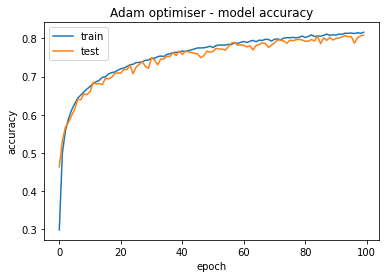

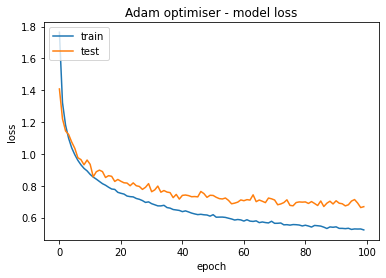

In [15]:
# list all data in history
print(emotion_model_info.history.keys())
# summarize history for accuracy
plt.plot(emotion_model_info.history['categorical_accuracy'])
plt.plot(emotion_model_info.history['val_categorical_accuracy'])
plt.title('Adam optimiser - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(emotion_model_info.history['loss'])
plt.plot(emotion_model_info.history['val_loss'])
plt.title('Adam optimiser - model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

-----------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
%load_ext tensorboard
%tensorboard --logdir path+'/Tensorboard/'

-------------------------------------------------------------------------------------------------------------------------------------------------

**Convolution Matrix**

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
target_names = list(emotion_dict.values())
print(target_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [19]:
y_pred=emotion_model.predict(train_generator)
y_pred=np.argmax(y_pred,axis=1)
print('confusion matrix')
cm=confusion_matrix(train_generator.classes,y_pred)
print(cm)

confusion matrix
[[1208 1451 1197 2089 1352 1321 1393]
 [1271 1329 1215 2040 1391 1374 1390]
 [1195 1332 1163 2113 1435 1390 1383]
 [2030 2222 1886 3391 2233 2222 2280]
 [1225 1358 1130 2169 1345 1375 1435]
 [1276 1416 1119 2223 1412 1350 1437]
 [1300 1367 1135 2140 1352 1341 1376]]


In [20]:
y_pred=emotion_model.predict(validation_generator)
y_pred=np.argmax(y_pred,axis=1)
print('confusion matrix')
cm=confusion_matrix(validation_generator.classes,y_pred)
print(cm)

confusion matrix
[[142  23 111 227 148 186 121]
 [  7   3  14  28  21  25  13]
 [137  19 132 226 181 195 134]
 [239  29 206 424 321 345 210]
 [187  23 138 294 207 233 151]
 [168  30 147 306 208 235 153]
 [101  18  95 225 131 160 101]]


C:\Users\logesh\AppData\Local\Temp/ipykernel_4128/2774912854.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_names)
C:\Users\logesh\AppData\Local\Temp/ipykernel_4128/2774912854.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_names)


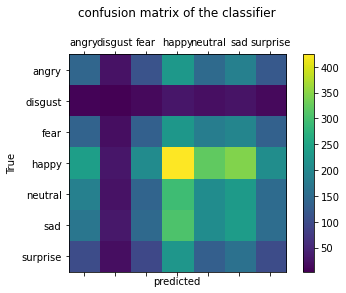

In [21]:
fig=plt.figure()
ax=fig.add_subplot(111)
cax=ax.matshow(cm)
plt.title('confusion matrix of the classifier\n')
fig.colorbar(cax)
ax.set_xticklabels([''] + target_names)
ax.set_yticklabels([''] + target_names)
plt.xlabel('predicted')
plt.ylabel('True')
plt.show()

In [22]:
Y_pred = emotion_model.predict(validation_generator, 400 // 4)

y_pred = np.argmax(Y_pred, axis=1)
print(validation_generator.classes)

print('Confusion Matrix')

cfm = confusion_matrix(validation_generator.classes, y_pred)

print(cfm)

[0 0 0 ... 6 6 6]
Confusion Matrix
[[114  15 110 228 171 187 133]
 [ 16   3  18  23  20  20  11]
 [143  24 124 241 172 199 121]
 [259  30 186 420 307 352 220]
 [168  31 152 308 185 236 153]
 [169  23 149 306 213 237 150]
 [112  19 104 204 149 148  95]]


In [23]:
print(classification_report(validation_generator.classes,y_pred))

              precision    recall  f1-score   support

           0       0.12      0.12      0.12       958
           1       0.02      0.03      0.02       111
           2       0.15      0.12      0.13      1024
           3       0.24      0.24      0.24      1774
           4       0.15      0.15      0.15      1233
           5       0.17      0.19      0.18      1247
           6       0.11      0.11      0.11       831

    accuracy                           0.16      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.16      0.16      7178



--------------------------------------------------------------------------------------------------------------------------------------------

In [24]:
# %%javascript
# IPython.notebook.save_notebook()

In [25]:
# #pip install twilio
# from twilio.rest import Client

In [26]:
# import json
 
# # Opening JSON file
# f = open(path+'/twilo.json')
 
# # returns JSON object as
# # a dictionary
# data = json.load(f)
 
# # Iterating through the json
# # list
# print(data)
 
# # Closing file
# f.close()

In [27]:
# message =f"Accuracy : {emotion_model_info.history['categorical_accuracy'][-1]} Loss : {emotion_model_info.history['loss'][-1]} val_accuracy : {emotion_model_info.history['val_categorical_accuracy'][-1]} val_loss : {emotion_model_info.history['val_loss'][-1]}"

# # # Your Account Sid and Auth Token from twilio account

# # # instantiating the Client
# client = Client(data['account_sid'], data['auth_token'])
# # # sending message
# message = client.messages.create(body=message, from_= '+917305746782', to='+917305746782')
# # # printing the sid after success
# print(message.sid)

In [28]:
import os
len(os.listdir(path+'/dataset/FacialExpression-Dataset/Train/angry'))

10011

In [29]:
# #compress tensorboard data and check ponits
# checkpoints = shutil.make_archive('Checkpoints', "zip", path+'/Checkpoints/zip')
# tensorboard = shutil.make_archive('Tensorboard',"zip",path+'/Tensorboard/zip')

In [30]:
# from google.colab import files
# from shutil import  copy2

# t = input("C to copy to drive , D to download")
# if t == 'c' or t == 'C':
#   copy2('/content/Checkpoints.zip','/content/drive/MyDrive/7thSem_project/Checkpoints.zip')
#   copy2('/content/Tensorboard.zip','/content/drive/MyDrive/7thSem_project/Tensorboard.zip')
# elif t == 'd' or t =='D':

#   files.download('/content/Checkpoints.zip')

#   files.download('/content/Tensorboard.zip')

------------------------------------------------------------------------------------------------------------------------------------------------------

In [31]:
# import cv2
# import numpy as np

In [32]:
# # start the webcam feed
# cap = cv2.VideoCapture(0)
# while True:
#     # Find haar cascade to draw bounding box around face
#     ret, frame = cap.read()
#     if not ret:
#         break
#     bounding_box = cv2.CascadeClassifier('C:\\Users\\logesh\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\cv2\\data\\haarcascade_frontalface_default.xml')
#     gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     num_faces = bounding_box.detectMultiScale(gray_frame,scaleFactor=1.3, minNeighbors=5)

#     for (x, y, w, h) in num_faces:
#         cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
#         roi_gray_frame = gray_frame[y:y + h, x:x + w]
#         cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)
#         emotion_prediction = emotion_model.predict(cropped_img)
#         maxindex = int(np.argmax(emotion_prediction))
#         cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

#     cv2.imshow('Facial Expression', cv2.resize(frame,(1200,860),interpolation = cv2.INTER_CUBIC))    
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

In [33]:
# cap.release()
# cv2.destroyAllWindows()

In [34]:
stop_cuda()

In [1]:
# import seaborn
# import matplotlib.pyplot as plt
 
 
# def plot_confusion_matrix(data, labels, output_filename):
#     """Plot confusion matrix using heatmap.
 
#     Args:
#         data (list of list): List of lists with confusion matrix data.
#         labels (list): Labels which will be plotted across x and y axis.
#         output_filename (str): Path to output file.
 
#     """
#     seaborn.set(color_codes=True)
#     plt.figure(1, figsize=(16, 10))
 
#     plt.title("Confusion Matrix")
 
#     seaborn.set(font_scale=1.4)
#     ax = seaborn.heatmap(data, fmt='g', annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
#     ax.set_xticklabels(labels)
#     ax.set_yticklabels(labels)
 
#     ax.set(ylabel="True Label", xlabel="Predicted Label")
#     plt.show()
#     plt.savefig(output_filename, bbox_inches='tight', dpi=300)
#     plt.close()


# cm = [[114,  15, 110, 228, 171, 187, 133],
#  [ 16,   3,  18,  23,  20,  20,  11],
#  [143,  24, 124, 241, 172, 199, 121],
#  [259,  30, 186, 420, 307, 352, 220],
#  [168,  31, 152, 308, 185, 236, 153],
#  [169,  23, 149, 306, 213, 237, 150],
#  [112,  19, 104, 204, 149, 148,  95]]
# target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
 

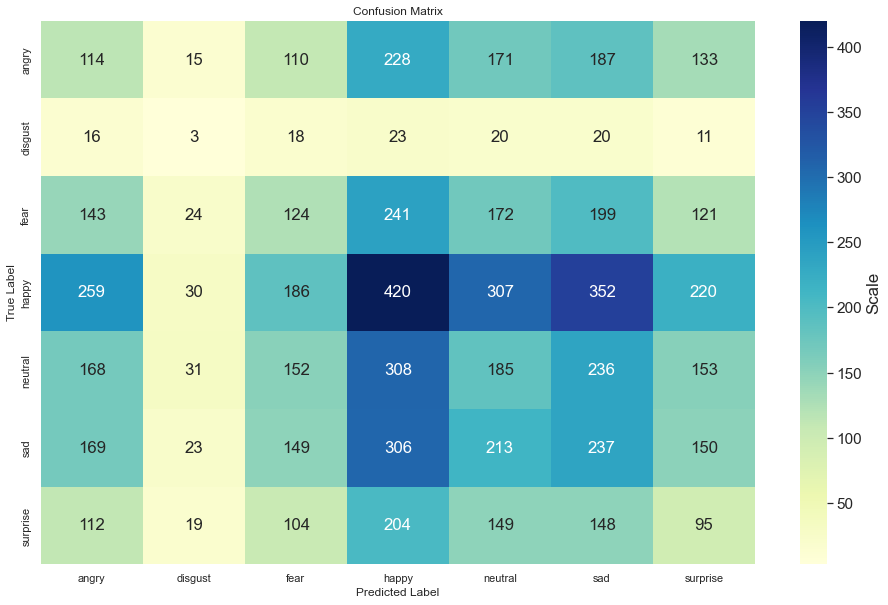

In [2]:
# plot_confusion_matrix(cm, target_names, "adam_confusion_matrix.png")

In [4]:
# import pandas as pd
# acc = [87.59,89.66,81.59,82.67]
# val = [83.59,83.83,80.86,81.01]
# model = ['SGD','Adagrad','Adam','Nadam']
# epoch = [78,56,100,101]

# df = pd.DataFrame({'Accuracy': acc,
#                    'Validate_Accuracy': val}, index=model)
# print(df)

         Accuracy  Validate_Accuracy
SGD         87.59              83.59
Adagrad     89.66              83.83
Adam        81.59              80.86
Nadam       82.67              81.01
